<a href="https://colab.research.google.com/github/lagonee23/price-prediction-models/blob/main/bitcoin_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 암호화폐(BitCoin)의 가격 예측 모델


### 필요 모듈 설치
> [pyupbit](https://github.com/sharebook-kr/pyupbit) 모듈은 업비트라는 암호화폐 거래소의 API를 파이썬에서 쉽게 사용하기 위해 개발되었습니다.
해당 라이브러리를 통해 암호화폐의 현재 가격, 매매 주문 등의 정보를 쉽게 얻어올 수 있습니다.

In [2]:
!pip install pyupbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.7 MB/s eta 0:00:00


### 업비트에서 일봉(day)차트의 데이터 가져오기
* `open`: 시가
* `high`: 고가
* `low`: 저가
* `close`: 종가
* `volume`: 거래량
* `value`: 거래대금

> 업비트는 한국 거래소이므로 데이터의 단위는 원화(￦)입니다.

In [108]:
import pyupbit

# UpBit에서 비트코인 가격 데이터 가져오기
df_origin = pyupbit.get_ohlcv("KRW-BTC", "day", count=2500, period=1)
df_origin

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2023-12-10 09:00:00,60082000.0,60277000.0,59563000.0,59835000.0,2575.294711,1.545037e+11
2023-12-11 09:00:00,59834000.0,59918000.0,55460000.0,56950000.0,11981.700488,6.909212e+11
2023-12-12 09:00:00,56950000.0,58780000.0,56654000.0,57605000.0,8005.139930,4.614287e+11
2023-12-13 09:00:00,57605000.0,59924000.0,56500000.0,59056000.0,5623.204158,3.260976e+11


In [109]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2272 entries, 2017-09-25 09:00:00 to 2023-12-14 09:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2272 non-null   float64
 1   high    2272 non-null   float64
 2   low     2272 non-null   float64
 3   close   2272 non-null   float64
 4   volume  2272 non-null   float64
 5   value   2272 non-null   float64
dtypes: float64(6)
memory usage: 124.2 KB


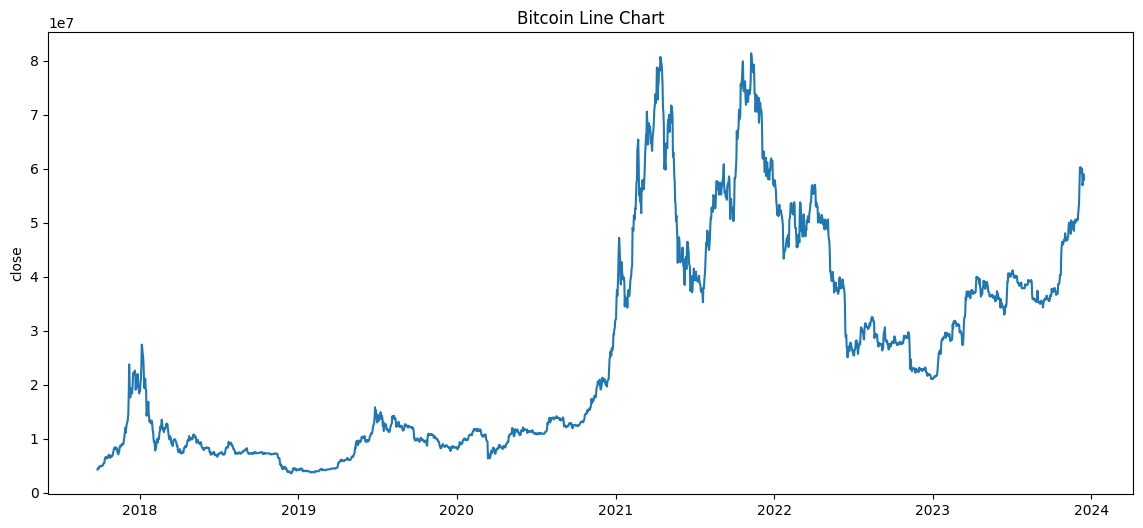

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_origin, x=df_origin.index, y='close')  # 비트코인 차트
plt.title('Bitcoin Line Chart');

## LSTM(Long Short Term Memory)
---
본 프로젝트에서는 long memory 특성을 보이는 비트코인의 가격 예측을 위한 딥러닝 모형으로 LSTM을 선택하였습니다.

> [LSTM(Long Short-Term Memory)](https://wikidocs.net/152773) 모델은 순환 신경망(Recurrent Neural Network, RNN)의 한 종류로서, 시퀀스 데이터를 처리하는 데 효과적입니다. LSTM은 RNN의 장기 의존성 문제를 해결하기 위해 고안되었습니다.

### 1. 데이터 전처리
* 일별 수익률(`Return`) 컬럼을 추가합니다.
* 필요 없는 컬럼(`volume`, `value`)을 제거합니다.
* 결측치(**null** or **nan**)를 제거합니다.

In [111]:
# 원본 복사
df = df_origin.copy()

df['Return'] = df['close'].pct_change()
df.drop(['volume', 'value'], axis=1, inplace=True)
df.head()

,open,high,low,close,Return
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,NaN
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,-0.000231
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,0.077760
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,-0.015246
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,0.015482


In [112]:
# 결측치 확인
df.isnull().sum()

open      0
high      0
low       0
close     0
Return    1
dtype: int64

In [113]:
# 결측치 제거
df.dropna(inplace=True)
df.isnull().sum()

open      0
high      0
low       0
close     0
Return    0
dtype: int64

* **특성(feature)**과 **타겟(target)** 변수를 정의합니다.
* `MinMaxScaler()`를 사용하여 최소/최대값이 각각 0, 1이 되도록 하고, 그 결과 모든 feature 값이 0~1 사이에 있게 됩니다.

$$ Y = \frac{X-X_{min}}{X_{max}-X_{min}} $$



In [114]:
from sklearn.preprocessing import MinMaxScaler

X = df[['open', 'high', 'low', 'Return']]  # features
y = df['close']  # target

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
df[['open', 'high', 'low', 'Return']] = X_scaler.fit_transform(X)
df['close'] = y_scaler.fit_transform(y.values.reshape(-1,1))

print("Data Shape:", df.shape)
df.head()

Data Shape: (2271, 5)


,open,high,low,close,Return
2017-09-26 09:00:00,0.008961,0.009277,0.009800,0.009025,0.529426
2017-09-27 09:00:00,0.009025,0.012555,0.009892,0.013345,0.654291
2017-09-28 09:00:00,0.013332,0.013757,0.012522,0.012432,0.505388
2017-09-29 09:00:00,0.012419,0.012960,0.011959,0.013345,0.554583
2017-09-30 09:00:00,0.013332,0.015326,0.014249,0.016404,0.611618


* 연속된 5일의 데이터를 하나의 **시퀀스**로 설정합니다.
* 학습 데이터는 전체 데이터의 70%로 합니다.

In [115]:
import math

sequence_length = 5

train_len = math.ceil(len(df) * 0.7)
train = df[0:train_len]
test = df[train_len - sequence_length:]

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)

Train data shape: (1590, 5)
Test data shape: (686, 5)


In [116]:
import numpy as np


train = train.values
test = test.values

# 학습 데이터
X_train, y_train = [], []

for i in range(sequence_length, len(train)):
    X_train.append(train[i-sequence_length:i, :])
    y_train.append(train[i, 3])

X_train, y_train = np.array(X_train), np.array(y_train)


# 테스트 데이터
X_test = []
y_test = y[train_len:].values

for i in range(sequence_length, len(test)):
    X_test.append(test[i-sequence_length:i, :])

X_test = np.array(X_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", y_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1585, 5, 5)
y_train shape: (1585,)
X_test shape: (681,)
y_test shape: (681,)


### 2. Modeling

In [117]:
import tensorflow as tf

# 하이퍼 파라미터(Hyperparameter)를 설정하여 모델을 정의합니다.
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 5)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1),
])

# 모델 컴파일
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 50)             11200     
                                                                 
 dropout_5 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_10 (Dense)            (None, 25)                1275      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 32701 (127.74 KB)
Trainable params: 32701 (127.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


학습을 진행합니다.

In [118]:
model.fit(X_train, y_train, batch_size=10, epochs=5)

Epoch 1/5
159/159 [==============================] - 54s 13ms/step - loss: 0.0043 - accuracy: 0.0013
Epoch 2/5
159/159 [==============================] - 1s 9ms/step - loss: 0.0018 - accuracy: 0.0013
Epoch 3/5
159/159 [==============================] - 1s 9ms/step - loss: 0.0015 - accuracy: 0.0013
Epoch 4/5
159/159 [==============================] - 1s 9ms/step - loss: 0.0014 - accuracy: 0.0013
Epoch 5/5
159/159 [==============================] - 2s 15ms/step - loss: 9.3529e-04 - accuracy: 0.0013


In [119]:
# 예측
y_pred = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred)

print()
print("Predection Shape:", y_pred.shape, end="\n\n")
print(y_pred[:5])

22/22 [==============================] - 1s 3ms/step

Predection Shape: (681, 1)

[[47317600.]
 [46815660.]
 [46251968.]
 [47711740.]
 [49159712.]]


### 3. 시각화

In [127]:
y_test.shape

(681, 1)

In [132]:
df_2 = df.iloc[train_len:]
df_2['y_test'] = y_scaler.inverse_transform(y_test.reshape(-1,1))
df_2['y_pred'] = y_pred
df_2

<ipython-input-132-fa8f1860e6b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['y_test'] = y_scaler.inverse_transform(y_test.reshape(-1,1))
<ipython-input-132-fa8f1860e6b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['y_pred'] = y_pred


,open,high,low,close,Return,y_test,y_pred
2022-02-02 09:00:00,0.567792,0.559577,0.547452,0.538645,0.454607,2.142123e+31,47317600.0
2022-02-03 09:00:00,0.538659,0.534266,0.539195,0.542734,0.540982,2.157089e+31,46815660.0
2022-02-04 09:00:00,0.542735,0.596823,0.548747,0.604417,0.697390,2.382893e+31,46251968.0
2022-02-05 09:00:00,0.604163,0.604986,0.610455,0.606410,0.534698,2.390187e+31,47711740.0
2022-02-06 09:00:00,0.606413,0.611745,0.612862,0.618546,0.559555,2.434614e+31,49159712.0
...,...,...,...,...,...,...,...
2023-12-10 09:00:00,0.725901,0.716218,0.732758,0.722719,0.523215,2.815958e+31,58949456.0
2023-12-11 09:00:00,0.722712,0.711675,0.679071,0.685629,0.452603,2.680184e+31,58929980.0
2023-12-12 09:00:00,0.685634,0.697273,0.694694,0.694050,0.548210,2.711009e+31,57789292.0
2023-12-13 09:00:00,0.694055,0.711751,0.692679,0.712704,0.570124,2.779296e+31,57400268.0


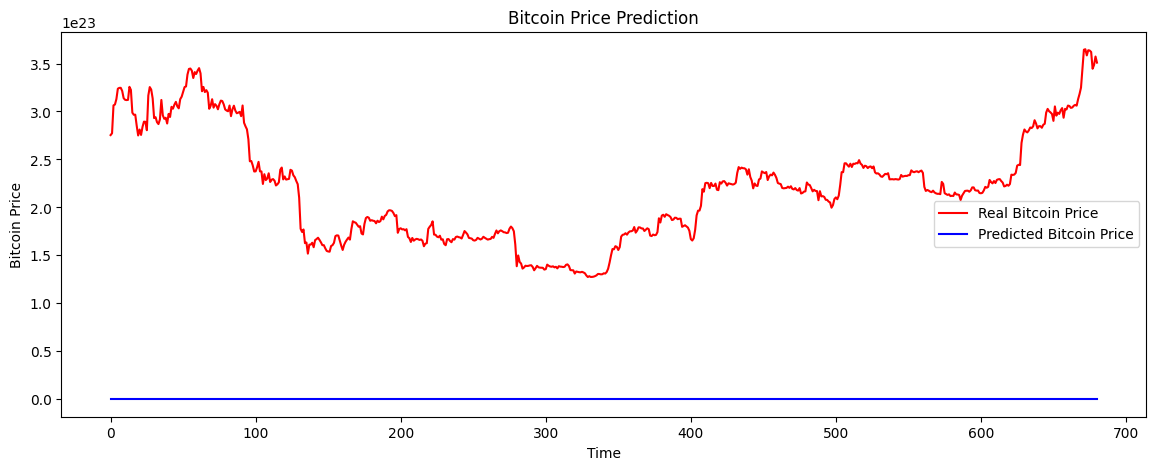

In [122]:
# 원본값(y_test)의 스케일링을 역으로 변환합니다.???????????????????????????
y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))

# 그래프를 그리기 위한 데이터 설정
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bitcoin Price')

# 그래프 제목 및 x, y 축 라벨 설정
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')

# 그래프에 레전드 설정
plt.legend()

# plt.figure(figsize=(14, 6))
# sns.lineplot(data=df_origin, x=df_origin.index, y='close')  # 비트코인 차트
# plt.title('Bitcoin Line Chart');

### 3. 성능평가

In [121]:
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 2912747829858131.0
